In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

with open('train_il_trajax.pkl', "rb") as f:
    data = pickle.load(f)
    trajax_imitation_losses = data['imitation_losses']
    trajax_model_losses = data['model_losses']
    trajax_times = data['times']

with open('train_il_diffmpc.pkl', "rb") as f:
    data = pickle.load(f)
    dmpc_imitation_losses = data['imitation_losses']
    dmpc_model_losses = data['model_losses']
    dmpc_times = data['times']

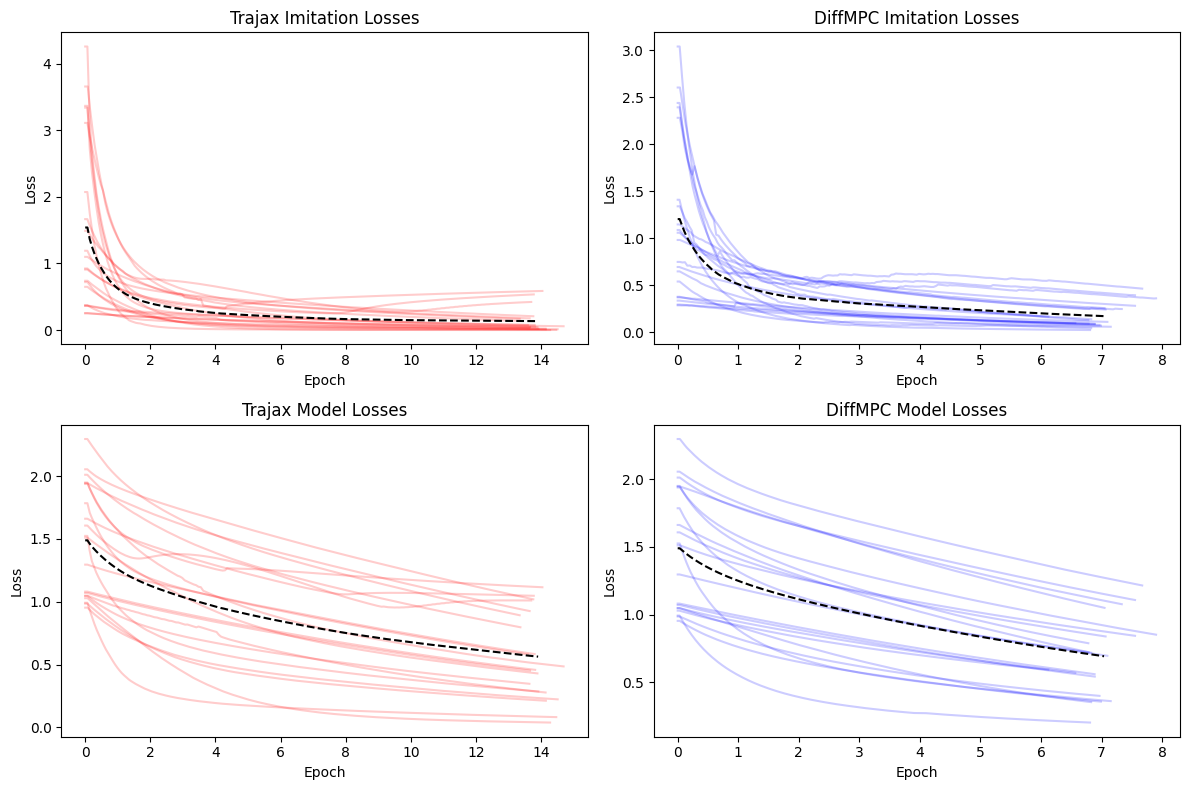

In [2]:
tj_im_norm = trajax_imitation_losses
dmpc_im_norm = dmpc_imitation_losses 
alpha=0.2

def plot_losses(axis, data, times, color):
    for i in range(data.shape[0]):
        axis.plot(times[i], data[i], color=color)
    axis.plot(np.mean(times, axis=0), np.mean(data, axis=0), color='black', linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

plot_losses(axs[0], trajax_imitation_losses, trajax_times, (1, 0, 0, alpha))
axs[0].set_title('Trajax Imitation Losses')
plot_losses(axs[1], dmpc_imitation_losses, dmpc_times, (0, 0, 1, alpha))
axs[1].set_title('DiffMPC Imitation Losses')
plot_losses(axs[2], trajax_model_losses, trajax_times, (1, 0, 0, alpha))
axs[2].set_title('Trajax Model Losses')
plot_losses(axs[3], dmpc_model_losses, dmpc_times, (0, 0, 1, alpha))
axs[3].set_title('DiffMPC Model Losses')

# Labeling axes
for ax in axs:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
plt.tight_layout()

plt.show()

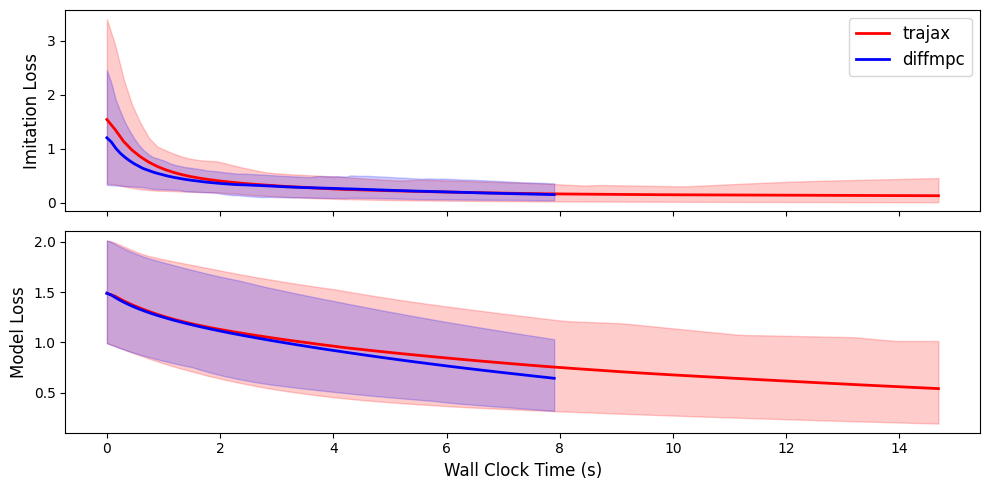

In [3]:

def plot_losses_w_percentiles(axis, data, times, color, label):
    N = 100
    time_rs = np.linspace(times.min(),times.max(),100)
    
    data_rs = np.zeros((data.shape[0],N))
    for ii in range(data.shape[0]):
        interpolator = interp1d(times[ii], data[ii], kind='linear', fill_value="extrapolate")
        data_rs[ii,:] = interpolator(time_rs)

    mean_rs = np.mean(data_rs, axis=0)
    p10_rs  =  np.percentile(data_rs, 10, axis=0)
    p90_rs  =  np.percentile(data_rs, 90, axis=0)
    axis.fill_between(time_rs, p10_rs, p90_rs, color=color, alpha=0.2)
    axis.plot(time_rs, mean_rs, color=color, label=label, linewidth=2)
    return np.concatenate((
        mean_rs.reshape((-1,1)),
        time_rs.reshape((-1,1)),
        p10_rs.reshape((-1,1)),
        p90_rs.reshape((-1,1))
    ), axis=1)

# === Create figure with two subplots ===
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

A = plot_losses_w_percentiles(axs[0], trajax_imitation_losses, trajax_times, 'red', 'trajax')
B = plot_losses_w_percentiles(axs[0], dmpc_imitation_losses,   dmpc_times, 'blue', 'diffmpc')
C = plot_losses_w_percentiles(axs[1], trajax_model_losses, trajax_times, 'red', 'trajax')
D = plot_losses_w_percentiles(axs[1], dmpc_model_losses,   dmpc_times, 'blue', 'diffmpc')

axs[0].legend(fontsize=12)
axs[0].set_ylabel('Imitation Loss', fontsize=12)
axs[1].set_xlabel('Wall Clock Time (s)', fontsize=12)
axs[1].set_ylabel('Model Loss', fontsize=12)

plt.tight_layout()
plt.show()

# Save data to CSV for visualization with tikz.
np.savetxt("IL_benchmark_data.csv", np.concatenate((A,B,C,D),axis=1), delimiter=",", fmt="%.5f")